# Evaluation

This notebook focuses on evaluating the trained models and interpreting their predictions:

1. Load the best-performing models
2. Evaluate models on the test set
3. Generate classification reports and confusion matrices


## Setup and Imports

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import scipy.sparse as sp

# Deep learning libraries
import torch
import torch.nn as nn

# Interpretability
import shap

# Visualization settings
plt.style.use('ggplot')
sns.set(style='whitegrid')
%matplotlib inline

## Load Models and Test Data

In [ ]:
#from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data'
features_dir = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/data/features'
models_dir = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/models'
results_dir = '/content/drive/MyDrive/Colab Notebooks/is5126/final-project/results'

#data_dir = '../data'
#features_dir = '../data/features'
#models_dir = '../models'
#results_dir = '../results'

# Load pre-split datasets
train_df = pd.read_csv(os.path.join(data_dir, 'twitter_training_clean.csv'))
val_df = pd.read_csv(os.path.join(data_dir, 'twitter_validation_clean.csv'))
test_df = pd.read_csv(os.path.join(data_dir, 'twitter_testing_clean.csv'))

# Extract labels
y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values
y_test = test_df['sentiment'].values

# Define a function to load features
def load_features(feature_type, feature_dir):
  if feature_type in ['bow', 'tfidf']:
    return (
      sp.load_npz(os.path.join(feature_dir, f'{feature_type}_features_train.npz')),
      sp.load_npz(os.path.join(feature_dir, f'{feature_type}_features_val.npz')),
      sp.load_npz(os.path.join(feature_dir, f'{feature_type}_features_test.npz'))
    )
  else:
    return (
      np.load(os.path.join(feature_dir, f'{feature_type}_features_train.npy')),
      np.load(os.path.join(feature_dir, f'{feature_type}_features_val.npy')),
      np.load(os.path.join(feature_dir, f'{feature_type}_features_test.npy'))
    )

# Load features using the function
X_bow_train, X_bow_val, X_bow_test = load_features('bow', features_dir)
X_tfidf_train, X_tfidf_val, X_tfidf_test = load_features('tfidf', features_dir)
X_word2vec_train, X_word2vec_val, X_word2vec_test = load_features('word2vec', features_dir)
X_glove_train, X_glove_val, X_glove_test = load_features('glove', features_dir)
X_bert_train, X_bert_val, X_bert_test = load_features('bert', features_dir)
print("Features loaded successfully.")

# Load the label encoder first (add this with your other imports)
with open(os.path.join(models_dir, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)


# Load model comparison results
model_results = pd.read_csv(os.path.join(results_dir, 'model_comparison_results.csv'))

# Get top performing models
top_models = model_results.head(5)  # Get top 5 models
print("Top 5 performing models:")
top_models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Features loaded successfully.
Top 5 performing models:


,Model,Feature,Accuracy,F1 Score
0,BERT,Fine-tuned,0.956620,0.956656
1,Random Forest,BoW,0.954449,0.954510
2,Random Forest,TF-IDF,0.953906,0.953967
3,BiLSTM (Optimized),BERT,0.903967,0.904289
4,Random Forest,BERT,0.903289,0.903277


In [ ]:
# Load label encoder
with open(os.path.join(models_dir, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

# Display label encoding
print("Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{i} -> {label}")

Label Encoding:
0 -> Irrelevant
1 -> Negative
2 -> Neutral
3 -> Positive


## 3. Load and Evaluate Best Models

In [ ]:
# Function to load a saved sklearn model
def load_sklearn_model(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    return model

# Function to load BiLSTM model
def load_bilstm_model(model_path, input_dim):
    # Define BiLSTM model class
    class BiLSTMClassifier(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, n_layers, dropout):
            super(BiLSTMClassifier, self).__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)
            self.fc = nn.Linear(hidden_dim * 2, output_dim)

        def forward(self, text):
            # text shape: [batch size, input dim]
            # We need to add sequence length dimension for LSTM
            text = text.unsqueeze(1)  # Now: [batch size, 1, input dim]

            output, (hidden, cell) = self.lstm(text)

            # Concatenate the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

            return self.fc(hidden)

    # Create model with same architecture
    hidden_dim = 128
    output_dim = len(label_encoder.classes_)
    n_layers = 2
    dropout = 0.5

    model = BiLSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout)

    # Load weights
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()

    return model, device

def predict_with_bert(model, X, max_length=128, batch_size=32):
    model.eval()
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    texts = X.tolist()

    all_predictions = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded_inputs = tokenizer(
            batch_texts,
            padding='max_length',
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
        input_ids = encoded_inputs['input_ids'].to(device)
        attention_mask = encoded_inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())

    return all_predictions


# Function to evaluate model and generate report
def evaluate_model(model, X_test, y_test, model_name, feature_name, is_bilstm=False, is_bert=False, device=None):
    if is_bilstm:
        # Predict using BiLSTM
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        with torch.no_grad():
            outputs = model(X_test_tensor)
            _, y_pred = torch.max(outputs, 1)
            y_pred = y_pred.cpu().numpy()
        y_test = label_encoder.transform(y_test)
    elif is_bert:
        y_pred = predict_with_bert(model, X_test)
        y_test = label_encoder.transform(y_test)
    else:
        # Predict using sklearn model
        y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Print results
    print(f"\n{model_name} with {feature_name} - Test Set Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name} with {feature_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, f'confusion_matrix_{model_name.lower()}_{feature_name.lower()}.png'))
    plt.show()

    return {
        'model_name': model_name,
        'feature_name': feature_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'report': report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred
    }

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader


def load_bert_model(model_path):
    num_labels = 4
    new_model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    saved_model = torch.load(model_path, map_location=device, weights_only=False)
    new_model.load_state_dict(saved_model.state_dict())

    new_model.to(device)
    new_model.eval()

    return new_model


Evaluating BERT with Fine-tuned...


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


BERT with Fine-tuned - Test Set Performance:
Accuracy: 0.9602
F1 Score (weighted): 0.9603

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.98      0.94      0.96      3845
    Negative       0.97      0.96      0.97      6684
     Neutral       0.94      0.97      0.96      5406
    Positive       0.95      0.96      0.96      6172

    accuracy                           0.96     22107
   macro avg       0.96      0.96      0.96     22107
weighted avg       0.96      0.96      0.96     22107



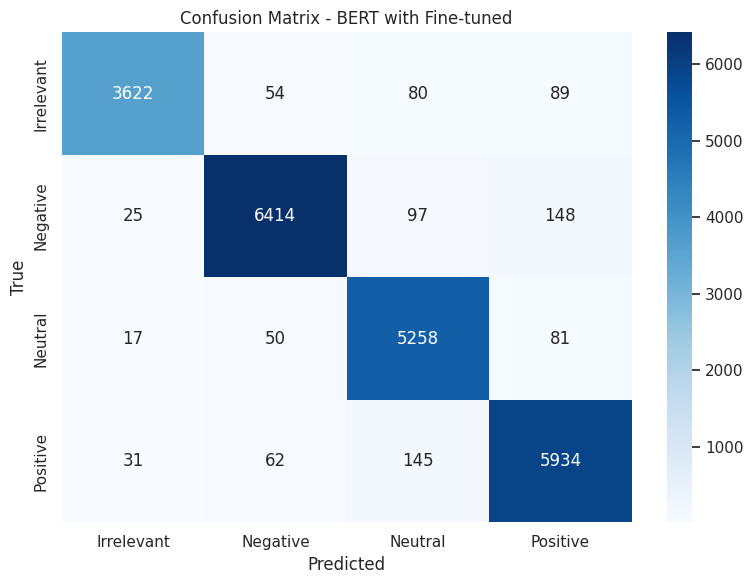


Evaluating Random Forest with BoW...

best_rf with BoW - Test Set Performance:
Accuracy: 0.9565
F1 Score (weighted): 0.9565

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.97      0.94      0.96      3845
    Negative       0.97      0.96      0.96      6684
     Neutral       0.93      0.97      0.95      5406
    Positive       0.96      0.95      0.96      6172

    accuracy                           0.96     22107
   macro avg       0.96      0.96      0.96     22107
weighted avg       0.96      0.96      0.96     22107



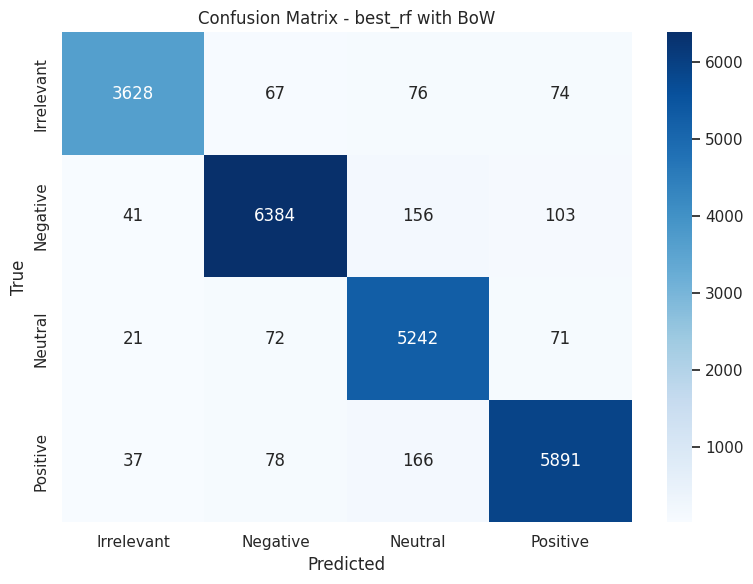


Evaluating Random Forest with TF-IDF...
This model was not saved because it's not the best for Random Forest

Evaluating BiLSTM (Optimized) with BERT...

BiLSTM (Optimized) with BERT - Test Set Performance:
Accuracy: 0.8443
F1 Score (weighted): 0.8450

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.77      0.88      0.82      3845
    Negative       0.92      0.82      0.86      6684
     Neutral       0.83      0.85      0.84      5406
    Positive       0.84      0.85      0.84      6172

    accuracy                           0.84     22107
   macro avg       0.84      0.85      0.84     22107
weighted avg       0.85      0.84      0.84     22107



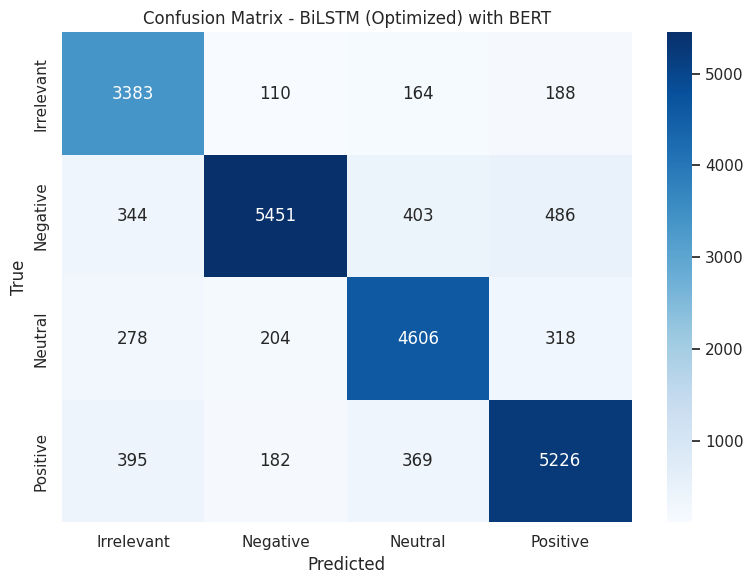


Evaluating Random Forest with BERT...
This model was not saved because it's not the best for Random Forest


In [ ]:
# Evaluate each top model
test_results = []

for _, row in top_models.iterrows():
    model_name = row['Model']
    feature_name = row['Feature']

    print(f"\nEvaluating {model_name} with {feature_name}...")

    # Load the appropriate test set
    if feature_name == 'BoW':
        X_test_features = X_bow_test
    elif feature_name == 'TF-IDF':
        X_test_features = X_tfidf_test
    elif feature_name == 'Word2Vec':
        X_test_features = X_word2vec_test
    elif feature_name == 'GloVe':
        X_test_features = X_glove_test
    elif feature_name == 'BERT':
        X_test_features = X_bert_test
    elif feature_name == 'Fine-tuned':
        X_test_features = test_df['cleaned_content']

    # Load the model
    if model_name == 'BiLSTM (Optimized)':
        model_path = os.path.join(models_dir, f'bilstm_{feature_name.lower()}.pt')
        if not os.path.exists(model_path):
            print("This model was not saved because it's not the best for BiLSTM")
        else:
            model, device = load_bilstm_model(model_path, X_test_features.shape[1])
            result = evaluate_model(model, X_test_features, y_test, model_name, feature_name, is_bilstm=True, device=device)
    elif model_name == 'BERT':
        model_path = os.path.join(models_dir, f'best_{model_name.lower()}_{feature_name.lower()}.pt')
        if not os.path.exists(model_path):
            print("This model was not saved because it's not the best for Bert")
        else:
            model = load_bert_model(model_path)
            result = evaluate_model(model, X_test_features, y_test, model_name, feature_name, is_bert=True)
    else:
        origin_model_name = model_name
        if model_name == 'Logistic Regression':
            model_name = 'best_logistic_regression'
        elif model_name == 'Random Forest':
            model_name = 'best_rf'
        model_path = os.path.join(models_dir, f'{model_name.lower()}_{feature_name.lower()}.pkl')
        if not os.path.exists(model_path):
            print(f"This model was not saved because it's not the best for {origin_model_name}")
        else:
            model = load_sklearn_model(model_path)
            result = evaluate_model(model, X_test_features, y_test, model_name, feature_name)

    test_results.append(result)

In [ ]:
with open(results_dir + '/evaluation_results.pkl', 'wb') as f:
    pickle.dump(test_results, f)